In [1]:
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install nba_api

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
!{sys.executable} -m pip install ipywidgets

In [4]:
!pip3 install scikit-learn

In [5]:
%pip install lxml requests pandas -q

import pandas as pd
import requests
import time
from io import StringIO

# --- 1. DATA INGESTION (AUTOMATED VIA BASKETBALL-REFERENCE) ---
# Goal: Scrape live data from Basketball-Reference safely.

def fetch_wemby_live_data():
    print("Connecting to Basketball-Reference...")
    
    seasons = [2024, 2025, 2026]
    all_games = []
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
    }
    
    for season in seasons:
        print(f"   Downloading season {season}...")
        url = f"https://www.basketball-reference.com/players/w/wembavi01/gamelog/{season}"
        
        try:
            response = requests.get(url, headers=headers, timeout=15)
            
            if response.status_code == 200:
                tables = pd.read_html(StringIO(response.text), match="Date")
                if tables:
                    df_season = tables[0]
                    df_season['Season_Year'] = season
                    all_games.append(df_season)
                    print(f"      Success! ({len(df_season)} rows extracted)")
                else:
                    print(f"      Failed: No table found for {season}.")
            elif response.status_code == 429:
                print(f"      BLOCKED (Error 429). The website thinks you are a bot.")
            elif response.status_code == 404:
                print(f"      Skipped: Season {season} doesn't exist yet (Normal).")
            else:
                print(f"      Failed with HTTP Status {response.status_code}")
                
            time.sleep(5) 
            
        except Exception as e:
            print(f"   Skipped {season} (Reason: {e})")
            time.sleep(5)
            
    if not all_games:
        raise ValueError("Critical Error: Could not fetch any data.")
        
    df_raw = pd.concat(all_games, ignore_index=True)
    
    # --- Clean Data ---
    # 1. Keep only rows where points are numbers (drops DNP - Did Not Play)
    df_raw['PTS_numeric'] = pd.to_numeric(df_raw['PTS'], errors='coerce')
    df_raw = df_raw.dropna(subset=['PTS_numeric']).copy()
    
    df_raw['Date_clean'] = pd.to_datetime(df_raw['Date'], errors='coerce')
    df_raw = df_raw.dropna(subset=['Date_clean']).copy()
    
    # 3. Build our final clean DataFrame
    df_clean = pd.DataFrame()
    df_clean['Date'] = df_raw['Date_clean']
    df_clean['Season'] = df_raw['Season_Year']
    
    df_clean['Is_Home'] = df_raw.iloc[:, 5].apply(lambda x: 0 if str(x) == '@' else 1)
    df_clean['Opponent'] = df_raw['Opp']
    df_clean['Win/Lose'] = df_raw.iloc[:, 7].astype(str).str[0]
    
    # Stats
    df_clean['Points'] = df_raw['PTS_numeric'].astype(int)
    df_clean['Rebounds'] = pd.to_numeric(df_raw['TRB']).astype(int)
    df_clean['Assists'] = pd.to_numeric(df_raw['AST']).astype(int)
    df_clean['Blocks'] = pd.to_numeric(df_raw['BLK']).astype(int)
    df_clean['Steals'] = pd.to_numeric(df_raw['STL']).astype(int)
    
    # Minutes
    df_clean['Minutes'] = df_raw['MP'].apply(lambda x: int(str(x).split(':')[0]) if ':' in str(x) else 0)
    
    # Chronological sort & Fatigue
    df_clean = df_clean.sort_values(by='Date').reset_index(drop=True)
    df_clean['Rest_Days'] = df_clean['Date'].diff().dt.days.fillna(3)
    df_clean['Date'] = df_clean['Date'].dt.strftime('%Y-%m-%d')
    
    return df_clean

# --- EXECUTION ---
try:
    df_all = fetch_wemby_live_data()
    df_all.to_csv('wemby_career_enriched.csv', index=False)
    
    print(f"\nDONE! {len(df_all)} total games loaded successfully (Totals rows removed).")
    print("\nLatest game imported:")
    print(df_all[['Date', 'Season', 'Opponent', 'Points']].tail(1))
    
except Exception as e:
    print(f"\nCRITICAL ERROR: {e}")

Note: you may need to restart the kernel to use updated packages.
Connecting to Basketball-Reference...
      Success! (89 rows extracted)
      Success! (89 rows extracted)
      Success! (62 rows extracted)

DONE! 160 total games loaded successfully (Totals rows removed).

Latest game imported:
           Date  Season Opponent  Points
159  2026-02-23    2026      DET      21


--- Analyzing Season 2026 ---
Total games played this season: 43
Average Points: 24.2
Average Rebounds: 11.3
Average Assists: 2.9
Average Blocks: 2.8
------------------------------


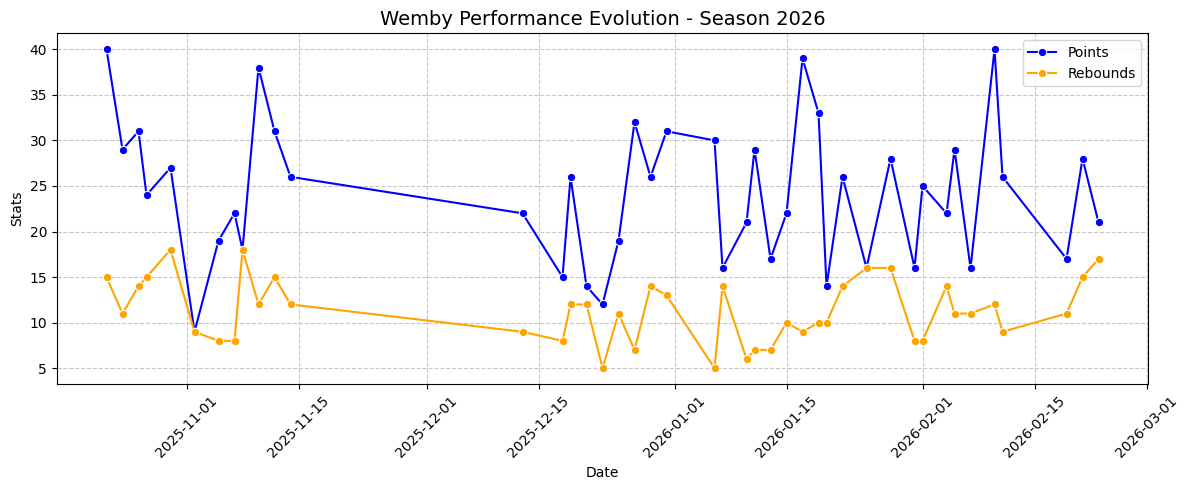

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- PART 1.5: DESCRIPTIVE ANALYSIS ---
# Goal: Analyze Victor Wembanyama's current season trends.

# 1. Load the dataset
df = pd.read_csv('wemby_career_enriched.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Automatically filter for the LATEST season available in data
current_season = df['Season'].max() 
df_current = df[df['Season'] == current_season].copy()

print(f"--- Analyzing Season {current_season} ---")
print(f"Total games played this season: {len(df_current)}")

# 2. Advanced Stats Detection & Averages
avg_pts = df_current['Points'].mean()
avg_reb = df_current['Rebounds'].mean()
avg_ast = df_current['Assists'].mean()
avg_blk = df_current['Blocks'].mean()

print(f"Average Points: {avg_pts:.1f}")
print(f"Average Rebounds: {avg_reb:.1f}")
print(f"Average Assists: {avg_ast:.1f}")
print(f"Average Blocks: {avg_blk:.1f}")
print("-" * 30)

# 3. Visualizations (Performance over time)
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_current, x='Date', y='Points', marker='o', label='Points', color='blue')
sns.lineplot(data=df_current, x='Date', y='Rebounds', marker='o', label='Rebounds', color='orange')

plt.title(f"Wemby Performance Evolution - Season {current_season}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Stats")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# --- PART 2: MACHINE LEARNING PREDICTOR (FULLY AUTOMATED) ---
# Goal: Calculate fatigue automatically based on the latest API data.

# 1. Feature Engineering
df = pd.read_csv('wemby_career_enriched.csv')
df['Date'] = pd.to_datetime(df['Date']) # Ensure Date is datetime

# Encode Opponent
le = LabelEncoder()
df['Opponent_Code'] = le.fit_transform(df['Opponent'])

# Calculate Rolling Form (Average of last 3 games)
cols = ['Points', 'Rebounds', 'Assists', 'Blocks', 'Steals']
for col in cols:
    df[f'Forme_{col}'] = df[col].rolling(window=3, closed='left').mean()

df_ml = df.dropna().copy()

# 2. Train Random Forest Models
features = ['Opponent_Code', 'Is_Home', 'Rest_Days', 'Forme_Points', 'Forme_Rebounds', 'Forme_Blocks']
targets = ['Points', 'Rebounds', 'Assists', 'Blocks', 'Steals']
models = {}
margins = {}

for target in targets:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(df_ml[features], df_ml[target])
    models[target] = model
    preds = model.predict(df_ml[features])
    margins[target] = np.mean(np.abs(preds - df_ml[target]))

# 3. The Smart Advisor Function
def wemby_advisor(opponent, is_home, match_date):
    if opponent not in le.classes_:
        return f"Error: Opponent '{opponent}' not found."
    
    # A. AUTOMATIC FATIGUE CALCULATION
    # We get the date of the absolute last game played from the API data
    last_game_date = pd.to_datetime(df_ml.iloc[-1]['Date'])
    target_date = pd.to_datetime(match_date)
    
    # We count the days difference
    delta = (target_date - last_game_date).days
    
    # Logic: 
    # If delta is 1 (or less), it's a Back-to-Back (Fatigue Max)
    # Otherwise, it's the real number of rest days.
    rest_days = max(1, delta)
    
    # Message for the user
    if rest_days <= 1:
        rest_msg = "1 Day (Back-to-Back detected)"
        rest_days = 1 # Force strict 1
    else:
        rest_msg = f"{rest_days} Days of Rest"
    
    # B. Prepare Input Data
    last_game = df_ml.iloc[-1]
    input_data = pd.DataFrame({
        'Opponent_Code': [le.transform([opponent])[0]],
        'Is_Home': [1 if is_home else 0],
        'Rest_Days': [rest_days],     # <--- AUTO-CALCULATED
        'Forme_Points': [last_game['Forme_Points']],
        'Forme_Rebounds': [last_game['Forme_Rebounds']],
        'Forme_Blocks': [last_game['Forme_Blocks']]
    })
    
    # C. Display Results
    loc_str = "Home" if is_home else "Away"
    print(f"\nWEMBY ADVISOR vs {opponent} ({loc_str})")
    print(f"Date: {target_date.date()} | Fatigue: {rest_msg}")
    print("="*60)
    print(f"{'STAT':<10} | {'SAFE BET (Low Risk)':<25} | {'VALUE BET (Target)':<25}")
    print("-" * 60)
    
    for target in targets:
        pred = models[target].predict(input_data)[0]
        margin = margins[target]
        safe_line = int(pred - margin)
        value_line = int(pred)
        print(f"{target:<10} | {f'Over {safe_line}.5':<25} | {f'Over {value_line}.5':<25}")
    print("="*60)

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime

# --- PART 3: INTERACTIVE DASHBOARD (CLEAN VERSION) ---
# Goal: Minimalist GUI with automatic fatigue detection.

# 1. Create Widgets
opponent_dropdown = widgets.Dropdown(
    options=sorted(le.classes_),
    description='Opponent:',
    style={'description_width': 'initial'}
)

location_radio = widgets.RadioButtons(
    options=[('Home', True), ('Away', False)],
    description='Location:',
    style={'description_width': 'initial'}
)

date_picker = widgets.DatePicker(
    description='Match Date:',
    value=datetime.date.today(),
    disabled=False
)

predict_button = widgets.Button(
    description='Generate Prediction',
    button_style='success',
    layout=widgets.Layout(width='50%', height='40px')
)

output_area = widgets.Output()

# 2. Logic
def on_button_click(b):
    with output_area:
        clear_output()
        if date_picker.value is None:
            print("Please select a valid date.")
            return
            
        # We only pass the 3 necessary arguments now
        wemby_advisor(
            opponent=opponent_dropdown.value, 
            is_home=location_radio.value,
            match_date=date_picker.value
        )

predict_button.on_click(on_button_click)

# 3. Display
print("\n--- WEMBY PREDICTOR DASHBOARD ---")
ui = widgets.VBox([
    opponent_dropdown, 
    location_radio, 
    date_picker, 
    predict_button
])
display(ui, output_area)


--- WEMBY PREDICTOR DASHBOARD ---


Output()